In [1]:
# load the packages for the assessment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import tensorflow as tf

# from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# from tensorflow.keras import layers, models

# from xgboost import XGBClassifier

In [2]:
# load the dataset
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.shape

(5110, 12)

In [5]:
# drop the id column since it is a unique identifier of each row. in addition it is not important in the analysis
df = df.drop('id', axis=1)

In [6]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
# rename the columns to lowercase for consistency 
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
df.shape

(5110, 11)

In [8]:
# set aside a 20% test set data before exploring the data.
# 
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df.stroke, random_state=42)

In [9]:
train_set.shape, test_set.shape

((4088, 11), (1022, 11))

- I have set aside 1022 observations of the dataset which I'll use to measure the performance of the model trained

### Data Exploration

In [10]:
# lets explore the training dataset to have an understanding of the data by copying it
df = train_set.copy()

# get the statistics for numeric attributes
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4088.000000,4088.000000,4088.000000,4088.000000,3918.000000,4088.000000
mean,43.353288,0.097114,0.054061,106.317167,28.922180,0.048679
std,22.596816,0.296148,0.226165,45.259652,7.928378,0.215223
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.312500,23.600000,0.000000
50%,45.000000,0.000000,0.000000,91.945000,28.000000,0.000000
75%,61.000000,0.000000,0.000000,114.197500,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4088 entries, 845 to 5052
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                3918 non-null   float64
 9   smoking_status     4088 non-null   object 
 10  stroke             4088 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 383.2+ KB


- The dataset includes 7 numeric attributes [`age`, `hypertension`, `heart_disease`, `avg_glucose_level`, `bmi` and `stroke`]
- In addition, the dataset includes 5 object attributes, that is, [`gender`, `ever_married`, `work_type`, `residence_type`, and `smoking_status`]

- Moreover, the `bmi` attribute shows there are 201 missing values

In [12]:
# create a function to categorize the patients into age-groups
def age_group_categories(age):
    if age >= 0 and age <= 1:
        return 'Infant'
    elif age >1 and age <= 3:
        return 'Toddler'
    elif age >3 and age <= 6:
        return 'Preschooler'
    elif age > 6 and age <= 12:
        return 'School Age'
    elif age > 12 and age < 20:
        return 'Teenager'
    elif age >= 20 and age <= 24:
        return 'Adolescense'
    elif age > 24 and age <= 39:
        return 'Adult'
    elif age > 39 and age <= 59:
        return 'Middle Aged'
    else:
        return 'Senior'

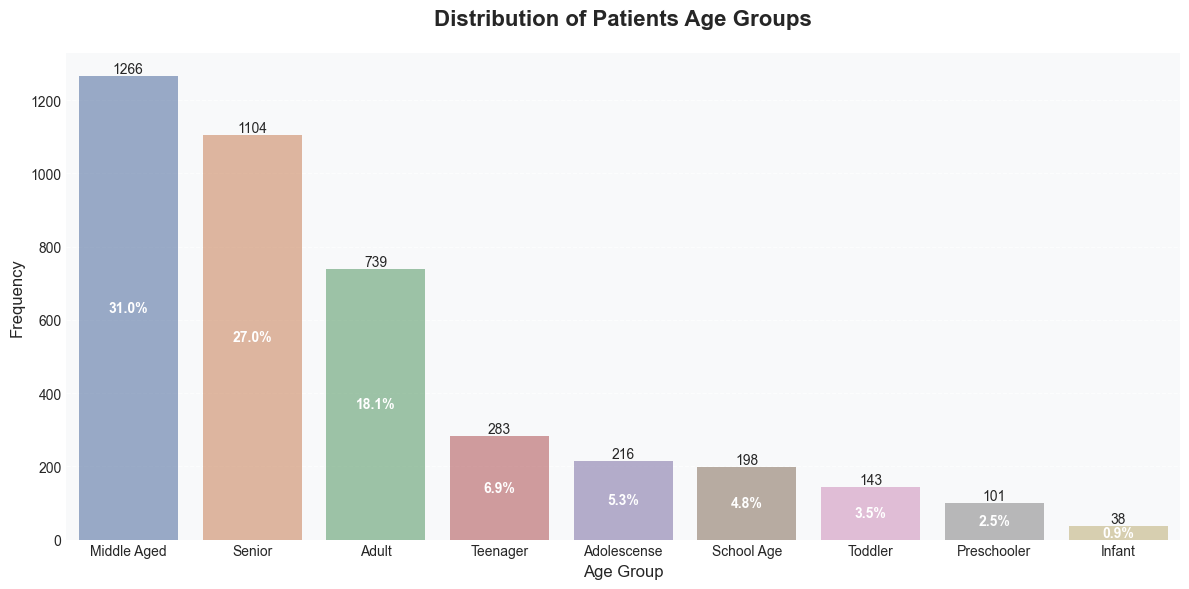

In [13]:
df['age_group'] = df['age'].apply(age_group_categories)

plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(12, 6))

age_counts = df['age_group'].value_counts()
ax = sns.barplot(x=age_counts.index, y=age_counts.values, hue=age_counts.index, palette='deep', alpha=0.6)

plt.title('Distribution of Patients Age Groups', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for i, v in enumerate(age_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=0)


ax.set_facecolor('#f8f9fa')


total = age_counts.sum()
for i, v in enumerate(age_counts.values):
    percentage = (v/total) * 100
    ax.text(i, v/2, f'{percentage:.1f}%', ha='center', va='center',color='white', fontweight='bold')

plt.tight_layout()

plt.show()

- the barplot above indicates that many of the patients **Middle Aged**, **Senior**, and **Adult**.

#### Distribution of the `stroke` attribute classes?

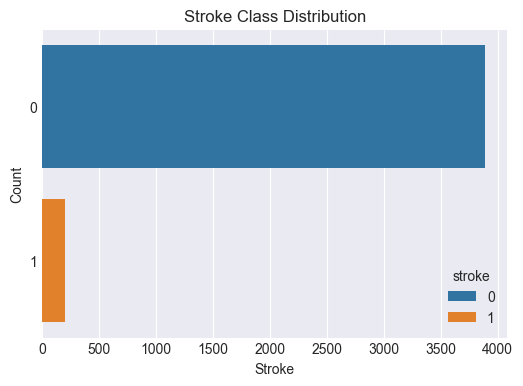

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(y='stroke', data=df, hue='stroke')
plt.title('Stroke Class Distribution')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

- From the bar plot above, there is an imbalance in the `stroke` attribute classes. 
    The number of patients who suffer from stroke is lower compared to patients who don't suffer from stroke.

#### Does age affect having a stroke?

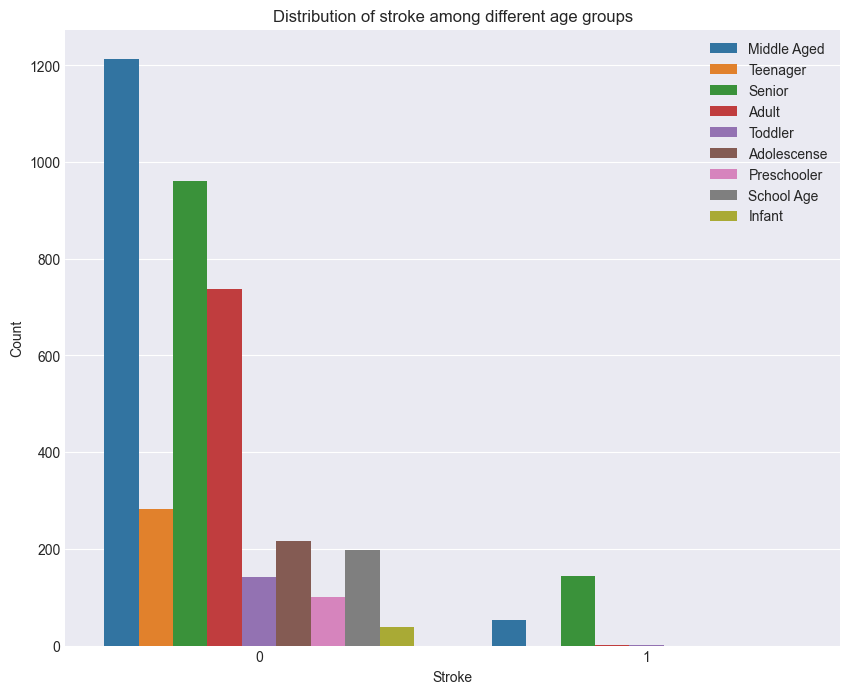

In [15]:
plt.figure(figsize=(10, 8))
sns.countplot(df, x='stroke', hue='age_group', palette=sns.color_palette('tab10')[:-1])
plt.title('Distribution of stroke among different age groups')
plt.ylabel('Count')
plt.xlabel('Stroke')
plt.legend(loc='upper right')
plt.show()

- the plot above illustrates that patients who suffer from stroke are either **Middle Aged** or **Senior**. With many Senior patients suffering the most because of their age.

#### Does work type affect having a stroke?

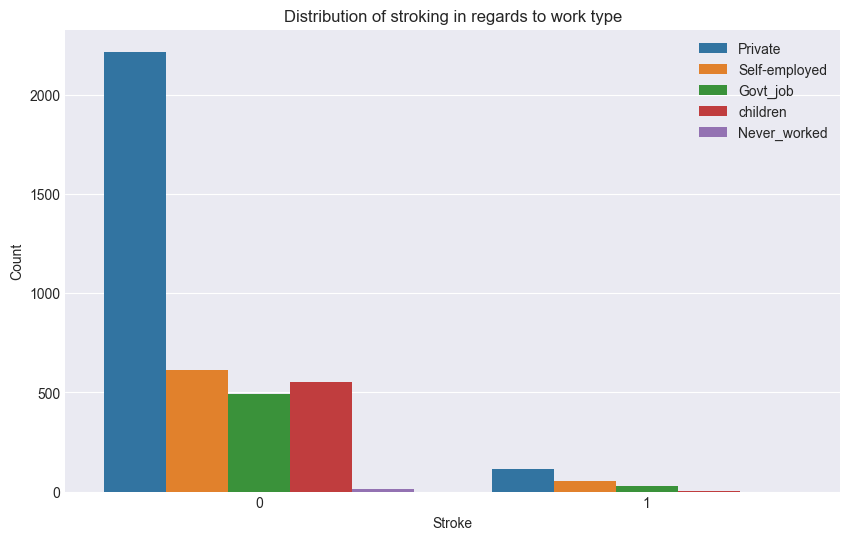

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(df, x='stroke', hue='work_type', palette=sns.color_palette('tab10')[:-5])
plt.title('Distribution of stroking in regards to work type')
plt.ylabel('Count')
plt.xlabel('Stroke')
plt.legend(loc='upper right')
plt.show()

- Many of the patients who suffer from stroke are either **Self employed** or  work in **Private** institutions

#### Does smoking affect having a stroke

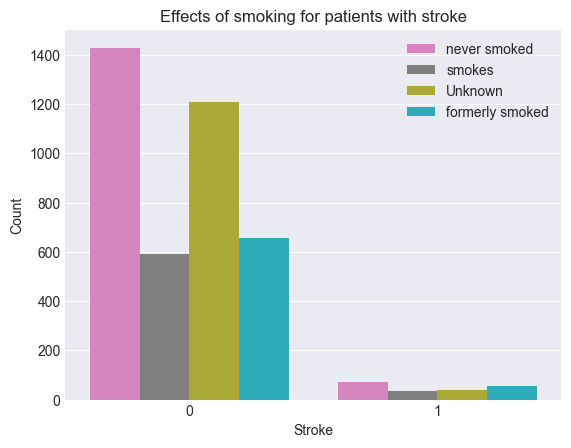

In [17]:
sns.countplot(df, x='stroke', hue='smoking_status', palette=sns.color_palette('tab10')[-4:])
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Effects of smoking for patients with stroke')
plt.legend(loc='upper right')

- The bar plot above indicates that many of the patients who suffered from stroke **never** smoked in their life. 
    The cause for having stroke to patients who never smoked before could be due to health issues. Thus further analysis should be considered

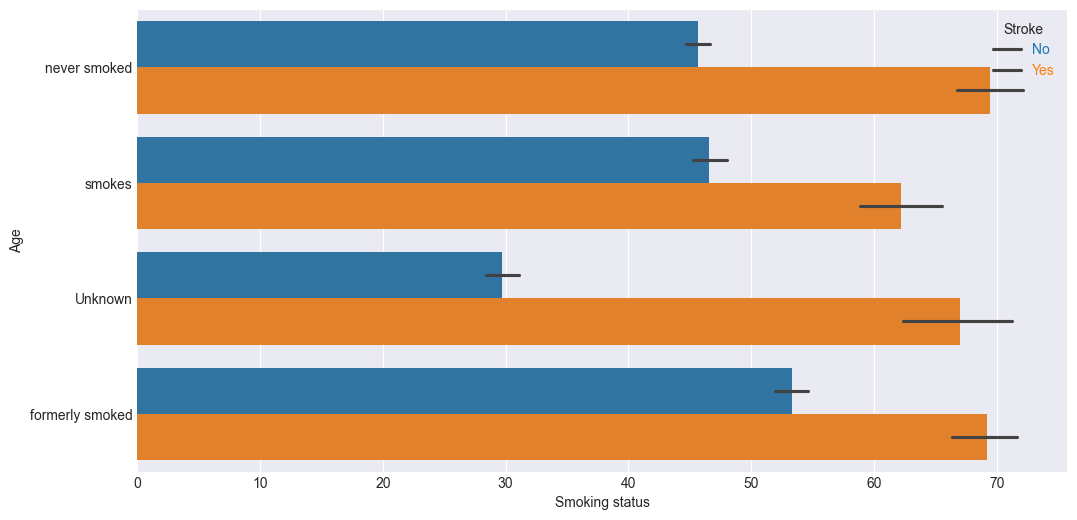

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(df, y='smoking_status', x='age',hue='stroke', palette=sns.color_palette('tab10')[:2])
plt.title('')
plt.ylabel('Age')
plt.xlabel('Smoking status')
plt.legend(loc='upper right', title='Stroke', labels=['No', 'Yes'], labelcolor=sns.color_palette('tab10')[:2])
plt.show()

- the bar plot above indicates that patients who never smoked were seniors thus age could be the main factor to suffering from stroke

Text(0.5, 0, 'Age')

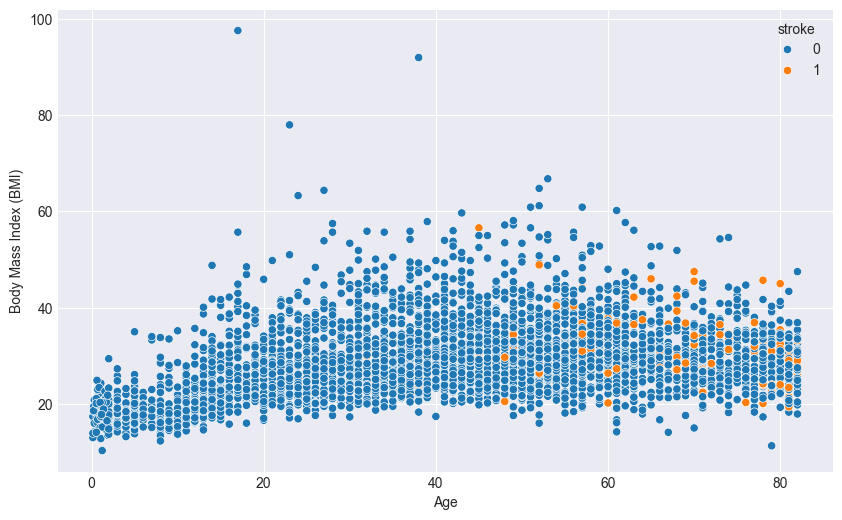

In [81]:
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='age', y='bmi', hue='stroke')
plt.title('')
plt.ylabel('Body Mass Index (BMI)')
plt.xlabel('Age')


- the scatter plot above indicates there is slightly positive corelation between age and body mass index.
    The plot indicates that patients with stroke have a bmi >= 20 and are above 40 yrs.

In [82]:
df[['age', 'bmi']].corr()

,age,bmi
age,1.00000,0.32848
bmi,0.32848,1.00000


### Data Preparation for Model Training

In [19]:
# check for missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  170
smoking_status         0
stroke                 0
age_group              0
dtype: int64

- the training set dataset indicates that are 156 missing observations for attribute `bmi`.

In [37]:
df.shape

(4088, 11)

In [20]:
df['stroke'].value_counts()

stroke
0    3889
1     199
Name: count, dtype: int64

In [13]:
# split the data into features (predictors) and target
X_train_full, y_train_full = df.drop('stroke', axis=1), df['stroke'].copy()

In [14]:
X_train_full.shape, y_train_full.shape

((4088, 10), (4088,))

In [15]:
# split the data into training_set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

In [16]:
X_train.shape, X_val.shape

((3270, 10), (818, 10))

In [18]:
# since the data is small I'll impute the missing values with the median value of the `bmi` attribute
# scikit-learn provides a transformer SimpleImputer that can handle this
imputer = SimpleImputer(strategy='median')

In [20]:
# select numeric attributes and subset that X_train data
num_attributes = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

df_num = X_train[num_attributes]

In [21]:
# train the imputer to the numeric features
imputer.fit(df_num)
imputer.statistics_

# transform the data and convert the returned numpy arrays to a dataframe
X = imputer.transform(df_num)

X_num = pd.DataFrame(X, columns=df_num.columns)
X_num.isnull().sum()

age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
dtype: int64

In [22]:
# create a pipeline that handle data imputation, scaling for numeric features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
])

In [23]:
# select categorical attributes
cat_attributes = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
df_cat = X_train[cat_attributes]

In [24]:
# to train a machine learning model, I have to convert the categorical attributes from object to numeric
# theScikit-learn library provides a Transformer that does this automatically OneHotEncoder, this transformer increases the number of features

# i'll illustrate how this transformer does using the `work_type` attribute
encoder = OneHotEncoder(sparse_output=False)
work_type_1hot = encoder.fit_transform(df_cat[['gender', 'work_type', 'residence_type']])
work_type_1hot[:5]

array([[1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]])

In [25]:
# I'll create a column pipeline for handling categorical attributes
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [26]:
# combine the pipelines into one pipeline
preprocessor = ColumnTransformer([
    ('numeric_pipeline', num_pipeline, num_attributes),
    ('cate_pipeline', cat_pipeline, cat_attributes),
])

#### Feature Extraction using AutoEncoder

In [27]:
# pass the training data to the pipeline
X_train_prepared = preprocessor.fit_transform(X_train)

In [57]:
# i'll use tensorflow and keras to create an autoencoder that extract the features 

# number of input feature
input_dim = X_train_prepared.shape[1]

# encoder 
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(8, activation='relu')(encoded)
latent = layers.Dense(4, activation='relu', name='latent_space')(encoded)

# decoder
decoded = layers.Dense(8, activation='relu')(latent)
decoded = layers.Dense(16, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# autoencoder
autoencoder = models.Model(inputs=input_layer, outputs=decoded)

# compile the autoencoder
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 21)                  │             357 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,065 (4.16 KB)

 Trainable params: 1,065 (4.16 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
history = autoencoder.fit(X_train_prepared, X_train_prepared, epochs=100, batch_size=16, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.1652 - val_loss: 0.1392
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1312 - val_loss: 0.1189
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.1037 - val_loss: 0.0867
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0779 - val_loss: 0.0706
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0662 - val_loss: 0.0617
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0593 - val_loss: 0.0551
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0540 - val_loss: 0.0508
Epoch 8/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0497 - val_loss: 0.0462
Epoch 9/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0467 - val_loss: 0.0437
Epoch 10/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0442 - val_loss: 0.0420
Epoch 11/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0422 - val_loss: 0.0400
Epoch 12/100
164/164 ━━━━━━━━

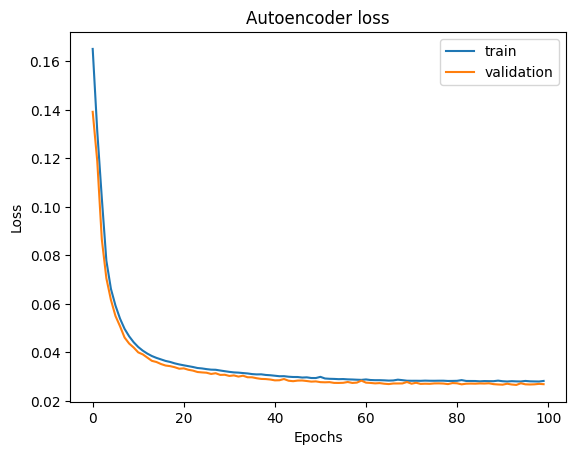

In [60]:
# plot the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Autoencoder loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [63]:
# define a new model that maps input ---> latent features:
encoder = models.Model(inputs=input_layer, outputs=latent)

# save the model
encoder.save('encoder.keras')

### Random Forest Classifier

In [87]:
# using the autoencoder to train the random forest classifier

# load the encoder
my_encoder = models.load_model('encoder.keras')

# preprocess the data using the preprocessor pipeline
X_train_prepared = preprocessor.fit_transform(X_train_full)
# predict the X_train data
X_train_encoded = my_encoder.predict(X_train_prepared)

# apply SMOTE to autoencoded features
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_encoded_res, y_train_res = smote.fit_resample(X_train_encoded, y_train_full)


forest = RandomForestClassifier(random_state=42, class_weight='balanced')
forest.fit(X_train_encoded_res, y_train_res)

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


- For feature extraction, I used a neural network autoencoder that takes the most important features and ignores the other features.

- The provided patients data, the stroke attribute (target) is very imbalanced. I used a SMOTE technique which generates synthetic instances
   of the minor class such both class are balanced. 

In [90]:
test_set.shape

(1022, 11)

In [91]:
# evaluate the model using the test set
X_test, y_test = test_set.drop('stroke', axis=1), test_set['stroke'].copy()
X_test_prepared = preprocessor.transform(X_test)

# use the encoder to extract features
X_test_encoded = my_encoder.predict(X_test_prepared)


y_prob = forest.predict_proba(X_test_encoded)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
ROC-AUC: 0.7285905349794239


In [93]:
# predict the training data and view the classification report
y_pred = forest.predict(X_test_encoded)
# report the classification report
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92       972
           1       0.12      0.34      0.18        50

    accuracy                           0.85      1022
   macro avg       0.54      0.61      0.55      1022
weighted avg       0.92      0.85      0.88      1022



In [96]:
forest_cm = confusion_matrix(y_test, y_pred)
forest_cm

array([[850, 122],
       [ 33,  17]])

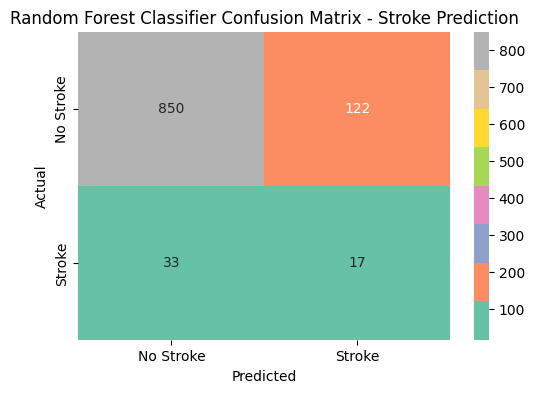

In [136]:
ran_df = pd.DataFrame(forest_cm, 
                      index=['No Stroke', 'Stroke'], 
                      columns=['No Stroke', 'Stroke'])

plt.figure(figsize=(6, 4))
sns.heatmap(ran_df, annot=True, fmt='d', cmap='Set2')
plt.title("Random Forest Classifier Confusion Matrix - Stroke Prediction")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

#### Fine tune the RandomForest classifier

In [95]:
# create an instance of the forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# define a dictionary of parameters to use
param_dist = {
    'n_estimators': [100, 300, 500, 800, 1000, 1200],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=20, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2, random_state=42)

rf_search.fit(X_train_encoded_res, y_train_res)

print("Best Parameters:", rf_search.best_params_)
print("Best CV ROC-AUC:", rf_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best CV ROC-AUC: 0.9496923637342461


In [97]:
# evaluate on the test set data not SMOTED
best_rf = rf_search.best_estimator_
y_pred_proba = best_rf.predict_proba(X_test_encoded)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.7164609053497942

In [98]:
y_pred_for = best_rf.predict(X_test_encoded)

print(classification_report(y_test, y_pred_for, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       972
           1       0.14      0.36      0.20        50

    accuracy                           0.86      1022
   macro avg       0.55      0.62      0.56      1022
weighted avg       0.92      0.86      0.89      1022



In [100]:
tuned_forest_cm = confusion_matrix(y_test, y_pred_for)
tuned_forest_cm

array([[857, 115],
       [ 32,  18]])

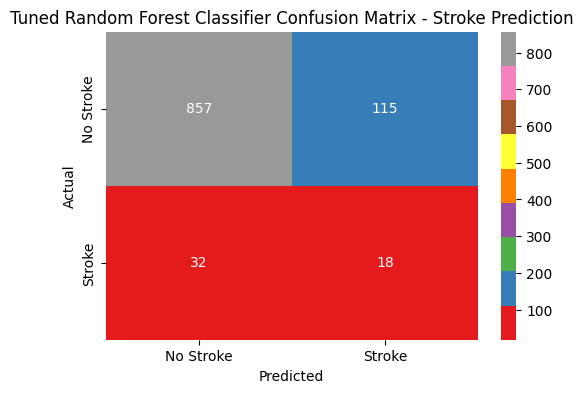

In [137]:
# display the confusion matrix in a table form

fr_df = pd.DataFrame(tuned_forest_cm, 
                      index=['No Stroke', 'Stroke'], 
                      columns=['No Stroke', 'Stroke'])

plt.figure(figsize=(6, 4))
sns.heatmap(fr_df, annot=True, fmt='d', cmap='Set1')
plt.title("Tuned Random Forest Classifier Confusion Matrix - Stroke Prediction")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Train XGBClassifier model

In [139]:
# create an instance of the XGBClassifier
weight = sum(y_train_full == 0) / sum(y_train_full == 1) # using the ratio of the imbalanced classes
xgb = XGBClassifier(scale_pos_weight=weight, eval_metric='logloss', random_state=42)
xgb.fit(X_train_encoded_res, y_train_res)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [140]:
# make predictions for the test data
y_pred = xgb.predict(X_test_encoded)

# compute the probabilities of the 
y_prob = xgb.predict_proba(X_test_encoded)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ROC-AUC: 0.7058333333333333


In [141]:
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       972
           1       0.10      0.54      0.16        50

    accuracy                           0.73      1022
   macro avg       0.53      0.64      0.50      1022
weighted avg       0.93      0.73      0.80      1022



In [142]:
xgb_cm = confusion_matrix(y_test, y_pred)
xgb_cm

array([[716, 256],
       [ 23,  27]])

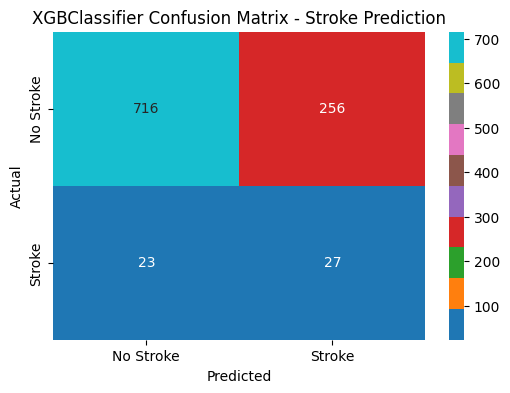

In [143]:
# display the confusion matrix in a table form

xgb_df = pd.DataFrame(xgb_cm, 
                      index=['No Stroke', 'Stroke'], 
                      columns=['No Stroke', 'Stroke'])

plt.figure(figsize=(6, 4))
sns.heatmap(xgb_df, annot=True, fmt='d', cmap='tab10')
plt.title("XGBClassifier Confusion Matrix - Stroke Prediction")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

#### Fine tune the XGBClassifier using cross-validation with RandomizedSearchCV

In [110]:
xgb = XGBClassifier(scale_pos_weight=weight, objective='binary:logistic', eval_metric='logloss', random_state=42)

params_grid = {
    'n_estimators': [200, 400, 600, 800, 1000, 1200],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}

# create an instance of random search and pass the parameters grid
xgb_search = RandomizedSearchCV(xgb, param_distributions=params_grid, n_iter=10, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2, random_state=42)

xgb_search.fit(X_train_encoded_res, y_train_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.005, 0.01, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [111]:
print(xgb_search.best_params_)

{'subsample': 0.8, 'n_estimators': 1200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [63]:
print("Best CV (Cross-validation) ROC-AUC:", xgb_search.best_score_)

Best CV (Cross-validation) ROC-AUC: 0.9463904947975997


In [146]:
# use the best params to train an xgbclassifier
best_xgb = XGBClassifier(
    scale_pos_weight=weight,
    n_estimators=1200,
    max_depth=7,               # use smaller depth
    min_child_weight=3,        # increase a bit to reduce overfitting
    subsample=0.8,
    gamma=0.3,
    colsample_bytree=0.8,
    learning_rate=0.1,
    reg_lambda=2.0,            # add regularization
    reg_alpha=1.0,             # L1 regularization
    random_state=42,
    eval_metric='auc'
)

# train the model
best_xgb.fit(X_train_encoded_res, y_train_res)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [147]:
# evaulate the model
y_pred = best_xgb.predict(X_test_encoded)

# predict the probabilities of the validation set
y_prob = best_xgb.predict_proba(X_test_encoded)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ROC-AUC: 0.7014609053497942


In [148]:
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       972
           1       0.12      0.54      0.19        50

    accuracy                           0.78      1022
   macro avg       0.54      0.67      0.53      1022
weighted avg       0.93      0.78      0.84      1022



In [149]:
fine_tuned_xgb = confusion_matrix(y_test, y_pred)
fine_tuned_xgb

array([[768, 204],
       [ 23,  27]])

In [151]:
y_test.value_counts()

stroke
0    972
1     50
Name: count, dtype: int64

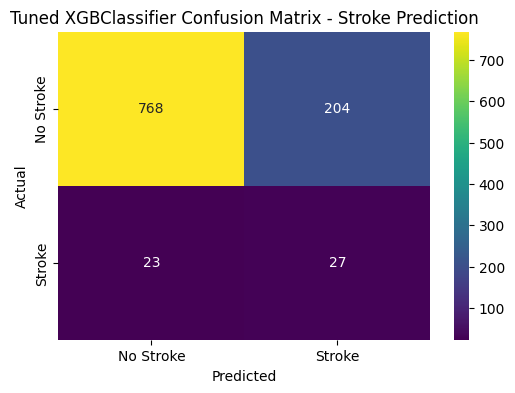

In [150]:
# display the confusion matrix in a table form

xgb_cm = pd.DataFrame(fine_tuned_xgb, 
                      index=['No Stroke', 'Stroke'], 
                      columns=['No Stroke', 'Stroke'])

plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='viridis')
plt.title("Tuned XGBClassifier Confusion Matrix - Stroke Prediction")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

- **NOTES**

    - Training a **RandomForestClassifier** without tuning the hyper-parameters, the model had an ROC AUC score of 72.8% but when you take a look
      at its confusion matrix mainly focusing on the last row, the number of instances that should be classified as stroke is 33 compared to the
      17 instances of patients with stroke.

    - I tuned the Random forest classifier using Random search cross validation, and found the best hyper-parameters. After training the model with
      the updated hyper-parameters, the model lowered its ROC AUC score to 71% but confusion matrix was better. The number of patients that should be
      predicted with chances of having a stroke increased by 1 (that is 18). The model is still perfect.
 
    - Since the random forest classifier did not have the best results, I trained a **XGBClassifier**. The model had an even lower ROC AUC score of 70.5%
      but looking at its confusion matrix, the outcome is way better that than random forest classifier. I tuned the hyper-parameters of the models to
      if the model would improve.
 
    - Looking at the tuned XGBClassifier ROC AUC score of 70% thus indicating no performance improvement, but its confusion matrix was much improved
      compared to the XGBClassifier that is not tuned.
 
    - The best model that I would choose to predict stroke risk is the tuned XGBClassifier.
 
    - Other models can be explored such as stacking together both Random Forest Classifier and XGBClassifier for a better performance.